# AutoEncoder

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split

In [45]:
def generate_random_2D_polynomial_function(max_degree):

    max_degree +=1
    # Generate 40x40 random coefficients with values between -2 and 2
    rand = 4*np.random.random((max_degree, max_degree)) - 2

    def poly_func(x,y):
        z=0
        for i in range(max_degree):
            for j in range(max_degree):
                if i+j < max_degree:
                    coeff = rand[i][j]
                    z += coeff*(x**i)*(y**j)
        return z

    return poly_func

def generate_images(sample_size, max_degree, image_size):
    images = []

    for i in range(sample_size):
        random_polynomial = generate_random_2D_polynomial_function(max_degree)
        image = np.zeros((image_size,image_size))

        # iterate through each pixel in the image
        for x_value in range(image_size):
            for y_value in range(image_size):
                image[x_value][y_value] = random_polynomial(x_value,y_value)

        images.append(image)

    return np.array(images)

def generate_train_test_data(sample_size, max_degree):
    return train_test_split(generate_images(sample_size, max_degree))

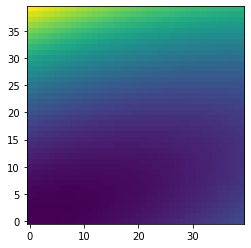

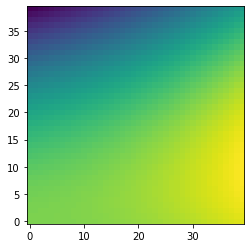

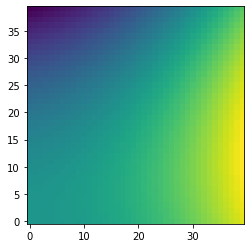

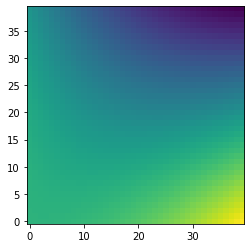

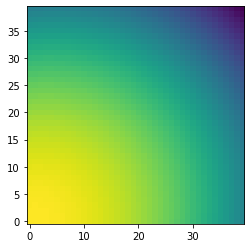

In [32]:
# Generate some sample images
samples = generate_images(sample_size=5, max_degree=2, image_size=40)
# Plot the generated samples
for img in samples:
    fig = plt.figure()
    plt.imshow(img, origin='lower')

In [33]:
# Generate data set
image_size = 40

try:
    data_set = np.load('poly_samples_10000.npy')
except:
    data_set = generate_images(10000, 2, image_size=image_size)
    data_set = utils.normalize(data_set)
    np.save('poly_samples_10000.npy', data_set)

x_train, x_test = train_test_split(data_set)

In [34]:
# Reshaping images for the autoencoders
number_of_train_samples = len(x_train)
number_of_test_samples = len(x_test)
x_train_reshaped = x_train.reshape(number_of_train_samples, image_size**2)
x_test_reshaped = x_test.reshape(number_of_test_samples, image_size**2)

# Define common parameters and Layers for both autoencoders
latent_dimensions = 2
encoded_input = Input(shape=(latent_dimensions,))
input_img = Input(shape=(image_size**2,))

def visualize_autoencoder_results(encoder, decoder):
    random_indexes = np.random.randint(0, 100, 5)
    encoded_images = encoder.predict(x_test_reshaped)
    decoded_images = decoder.predict(encoded_images)

    for random_index in random_indexes:
        actual_image = x_test[random_index]

        fig, axes = plt.subplots(1,2)

        axes[0].imshow(decoded_images[random_index].reshape(image_size,image_size), origin='lower')
        axes[0].title.set_text("Decoded image")
        axes[1].imshow(actual_image, origin='lower')
        axes[1].title.set_text("Actual image")

In [48]:
# Build encoder and decoder for simple autoencoder
encoded = Dense(latent_dimensions, activation='linear')(input_img)
encoder = Model(input_img, encoded)

decoded = Dense(1600, activation='linear')(encoded_input)
decoder = Model(encoded_input, decoded)

encoder_output = encoder(input_img)
autoencoder = decoder(encoder_output)

simple_autoencoder = Model(input_img, autoencoder)

simple_autoencoder.compile(optimizer='Adam', loss='mse')
simple_autoencoder.fit(x_train_reshaped, x_train_reshaped, validation_data=(x_test_reshaped, x_test_reshaped),
              batch_size=128, epochs=500,
              shuffle=True, verbose=0)

simple_autoencoder.summary()
simple_autoencoder.evaluate(x_test_reshaped, x_test_reshaped, verbose=1)

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1600)]            0         
_________________________________________________________________
model_27 (Model)             (None, 2)                 3202      
_________________________________________________________________
model_28 (Model)             (None, 1600)              4800      
Total params: 8,002
Trainable params: 8,002
Non-trainable params: 0
_________________________________________________________________
79/79 [==============================] - 0s 2ms/step - loss: 0.0024


0.0023747982922941446

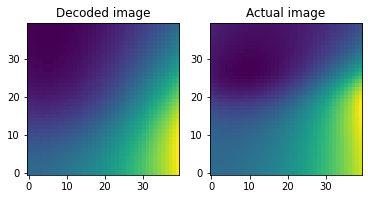

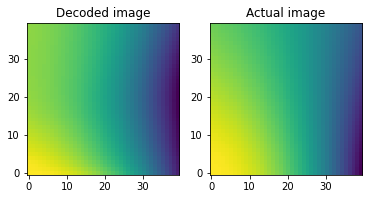

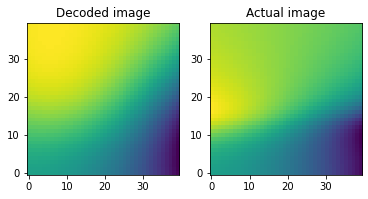

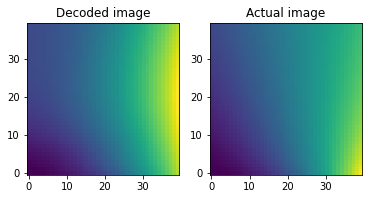

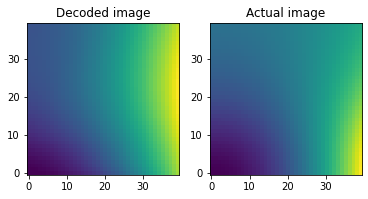

In [50]:
visualize_autoencoder_results(encoder, decoder)

In [54]:
# Build encoder and decoder for autoencoder with more hidden layers

encoded_2 = Dense(512, activation='relu')(input_img)
encoded_2 = Dense(64, activation='relu')(encoded_2)
encoded_2 = Dense(latent_dimensions, activation='linear')(encoded_2)

encoder_2 = Model(input_img, encoded_2)

decoded_2 = Dense(64, activation='relu')(encoded_input)
decoded_2 = Dense(512, activation='relu')(decoded_2)
decoded_2 = Dense(1600, activation='linear')(decoded_2)

decoder_2 = Model(encoded_input,decoded_2)

encoder_2_ouput = encoder(input_img)
complex_autoencoder = decoder(encoder_2_ouput)

complex_autoencoder = Model(input_img,complex_autoencoder)
complex_autoencoder.compile(optimizer='Adam', loss='mse')
complex_autoencoder.fit(x_train_reshaped, x_train_reshaped, validation_data=(x_test_reshaped, x_test_reshaped),
              batch_size=128, epochs=500,
              shuffle=True, verbose=0)

complex_autoencoder.summary()
complex_autoencoder.evaluate(x_test_reshaped,x_test_reshaped, verbose=1)

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1600)]            0         
_________________________________________________________________
model_27 (Model)             (None, 2)                 3202      
_________________________________________________________________
model_28 (Model)             (None, 1600)              4800      
Total params: 8,002
Trainable params: 8,002
Non-trainable params: 0
_________________________________________________________________
79/79 [==============================] - 0s 2ms/step - loss: 0.0024


0.0023806141689419746

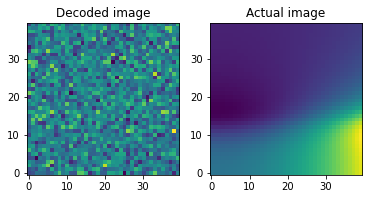

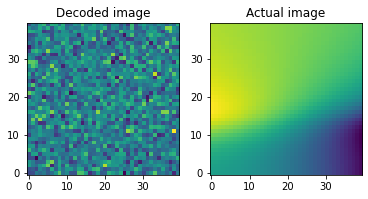

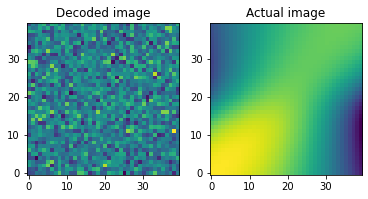

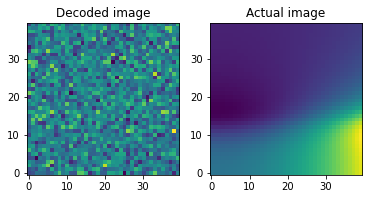

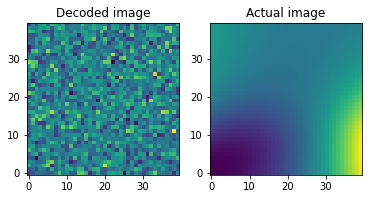

In [55]:
visualize_autoencoder_results(encoder_2, decoder_2)

As we can see, with just 2 latent dimensions, it is not possible to reconstruct the images since only two parameters are too little to encode more details of the image.

Now we want to visualize the results of our latent dimensions. Since our images will be encoded into two parameters, we will just use a scatter plot to visualize those two parameters.
Although we already know that results from reconstructions are poor, we still want to know if our encoder could do some basic clustering of our data.

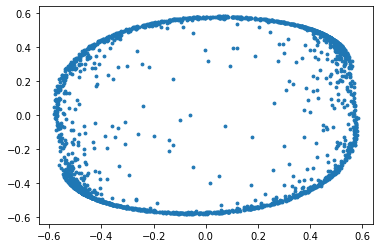

In [52]:
# Get encoded values for our simple encoder and plot them
encoded_images = encoder.predict(x_test_reshaped)
plt.scatter(encoded_images[:,0],encoded_images[:,1], s=8)

With our simple autoencoder, we see that the encoder clustered our images in two big categories. One cluster along the x axis and one cluster along the y axis.

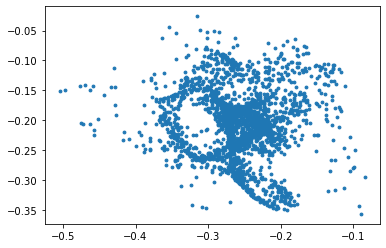

In [56]:
# Get encoded values for our simple encoder and plot them
encoded_images_2 = encoder_2.predict(x_test_reshaped)
plt.scatter(encoded_images_2[:,0],encoded_images_2[:,1], s=8)

In our more complex autoencoder, the encoder made one cluster along the y-axis. As also seen in our reconstructed images, with only two latent dimensions it is difficult to effectively encode all the information of the image. Thus we see that the encoder has difficulties to cluster the data.